---
title: "Diferencia salarial"
execute:
    echo: false
format: 
  html:
    code-fold: true
jupyter: python3
project:
  type: website
  output-dir: docs
---

### Diferencia salarial entre géneros 

Por una conversación que tuve hace tiempo, me quedó dando vuelta un aspecto particular respecto a la brecha salarial. Se sabe que en Chile y la mayoría de los países del mundo existe una brecha; los hombres, por ser hombres, ganan más que las mujeres. Me comentaron igual que, mirando mirando los sueldos por rol/nivel/posición en verdad no hay discriminación o la brecha se reduce. Si se mira en detalle los sueldos por género para cargos específicos la brecha no existe, pero si vemos la diferencia global efectivamente se aprecia una brecha significativa ¿La discriminación existe o no entonces?

Aquí aparece un tema clásico respecto a análisis de datos, las variables control, análisis causal y la [paradoja de Simpson](https://es.wikipedia.org/wiki/Paradoja_de_Simpson). Es de esos casos raros donde puede haber una droga que sea mala para los hombres, mala para las mujeres pero buena para las personas. En general estas conclusiones opuestas son resueltas teniendo definido el modelo causal, normalmente representados por grafos (Directed Acyclic Graphs o DAGs). Este tipo de modelos define las reglas necesarias para estimar los efectos de ciertas variables en otras, explicitando por cuales variables se debe controlar y por cuales no. 

Para este ejemplo, inventaré unos datos y haré un par de reflexiones respecto al sentido que tiene, o no, mirar estadísticas desglosadas a distintos niveles. Para generar los datos, supondré que el sueldo que gana una persona depende de su cargo/rol/posición pero además es influenciado por su género de la siguiente manera

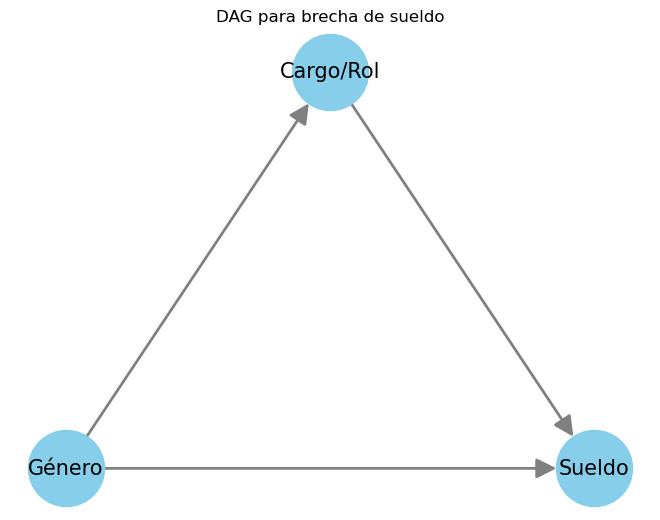

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['Género', 'Cargo/Rol', 'Sueldo']
G.add_nodes_from(nodes)

# Add edges (arrows) to represent causal relationships
G.add_edges_from([('Género', 'Cargo/Rol'), ('Cargo/Rol', 'Sueldo'), ('Género', 'Sueldo')])

# Define positions for the nodes
pos = {
    'Género': (0, 0),
    'Sueldo': (1, 0),
    'Cargo/Rol': (0.5, 1)
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, width=2, edge_color='gray', arrowsize=30)

plt.title('DAG para brecha de sueldo')
plt.show()

Para este ejemplo, tenemos que el género afecta indirectamente al sueldo a través del tipo de cargos al que pueden acceder (razonable supuesto, creo yo) y además afecta el sueldo directamente. El grafo "real" por supuesto puede ser mucho más complejo, incluyendo temas de educación, variables no observables y otros. De todas formas son un par de supuestos razonables que me ayudan a generar datos que coincidan con este grafo, y ver que pasa cuando se controla, o no, por la variable del cargo. Las reglas usadas son:

* Misma cantidad de hombres y mujeres (1000)
* Hombres entran en igual proporción a cargos con sueldos altos y con sueldos bajos
* Mujeres entran en un 70% a cargos con sueldos bajos y en un 30% a cargos con sueldos altos
* Los sueldos tienen algo de "ruido" con un error normal, +- algunas lucas
* Las mujeres tienen un mini bono ambos roles en cuanto a salario (para hacer el ejemplo más extremo)

A quien le interese puede ver el código asociado en mi [github](https://github.com/rrrventures/wage_gap). 


In [2]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Create gender data
n = 1000
gender = ['Hombre'] * n + ['Mujer'] * n

# Simulate role placement. Suppose 70% women are in low-paying roles and 50% men.
roles = np.random.choice(['Cargo bajo', 'Cargo alto'], size=n, p=[0.50, 0.50])
roles = np.concatenate([roles, np.random.choice(['Cargo bajo', 'Cargo alto'], size=n, p=[0.70, 0.30])])


In [3]:
# Assign wages based on roles. Add some noise. 
# Suppose low-paying roles get 500±5, high-paying get 1000±5.
# For the sake of Simpson's Paradox, let's have women earn slightly more in both roles.

wages = []

for i in range(2*n):
    base_wage = 500 if roles[i] == 'Cargo bajo' else 1000
    gender_bonus = 10 if gender[i] == 'Mujer' else 0
    
    wage = np.random.normal(base_wage + gender_bonus, 50)
    wages.append(wage)

# Create DataFrame
df = pd.DataFrame({'Gender': gender, 'Role': roles, 'Wage': wages})

Con los datos generados, vemos que la brecha global es de cerca de 100 lucas en promedio. Pero cuando hacemos el análisis por cargo, la brecha se revierte; las mujeres derechamente ganan más que los hombres tomando en cuenta el cargo. 

In [4]:
print(df.groupby(['Gender']).Wage.mean()) # Shows overall wage gap
print(df.groupby(['Gender', 'Role']).Wage.mean()) # Shows wage by role

Gender
Hombre    749.146391
Mujer     663.617914
Name: Wage, dtype: float64
Gender  Role      
Hombre  Cargo alto     999.512615
        Cargo bajo     501.766643
Mujer   Cargo alto    1012.555364
        Cargo bajo     509.038119
Name: Wage, dtype: float64


La razón: mirar la brecha por cargo equivale a anular el efecto que tiene el género sobre los cargos a los que acceden. Si el mayor efecto del género se encuentra en las oportunidades de acceso a educación o a ciertas carreras, y de esa manera influye en los cargos a los que pueden acceder, ver los datos de esta manera lo enmascara por completo. El grafo correspondiente a este análisis, donde controlamos por el cargo sería:

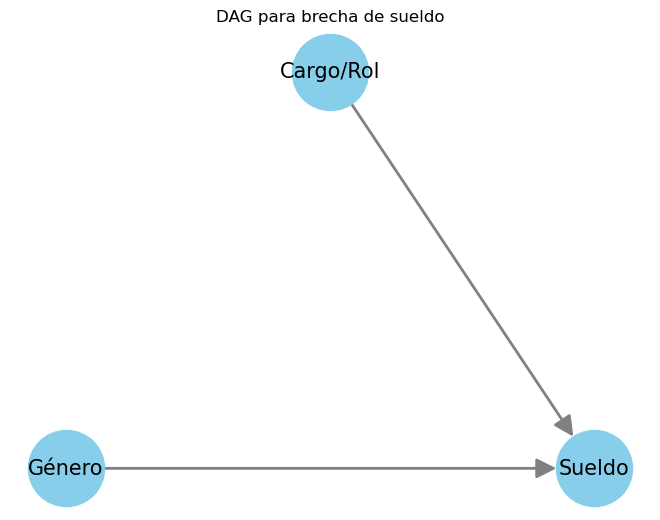

In [11]:
# Create a new directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['Género', 'Cargo/Rol', 'Sueldo']
G.add_nodes_from(nodes)

# Add edges (arrows) to represent causal relationships
G.add_edges_from([('Cargo/Rol', 'Sueldo'), ('Género', 'Sueldo')])

# Define positions for the nodes
pos = {
    'Género': (0, 0),
    'Sueldo': (1, 0),
    'Cargo/Rol': (0.5, 1)
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, width=2, edge_color='gray', arrowsize=30)

plt.title('DAG para brecha de sueldo')
plt.show()

Esto significa que TODO el efecto indirecto del género sobre el sueldo se anula, y por lo tanto no estamos viendo el efecto total real del género en los sueldos finales. Como tenemos el modelo completamente definido, podemos calcular el efecto directo e indirecto con un par de regresiones:

In [6]:
%%capture
import statsmodels.api as sm
import pandas as pd

# Recode gender as numeric (Male: 0, Female: 1)
df['Gender_num'] = df['Gender'].map({'Hombre': 0, 'Mujer': 1})

# Recode role as numeric (Low-paying role: 0, High-paying role: 1)
df['Role_num'] = df['Role'].map({'Cargo bajo': 0, 'Cargo alto': 1})

# Total effect
model_total = sm.OLS(df['Wage'], sm.add_constant(df['Gender_num'])).fit()
c = model_total.params['Gender_num']

# Effect of Gender on Role using Logistic Regression
model_a = sm.Logit(df['Role_num'], sm.add_constant(df['Gender_num'])).fit()
a_log_odds = model_a.params['Gender_num']
a_probability_diff = (np.exp(a_log_odds) / (1 + np.exp(a_log_odds))) - 0.5  # Subtract 0.5 to get difference for male vs. female

# Effect of Role on Wage controlling for Gender
model_b = sm.OLS(df['Wage'], sm.add_constant(df[['Gender_num', 'Role_num']])).fit()
b = model_b.params['Role_num']
c_prime = model_b.params['Gender_num']

# Direct and Indirect effects
direct_effect = c_prime
indirect_effect = a_probability_diff * b



In [7]:
print(f"Efecto directo (c'): {direct_effect}")
print(f"Efecto indirecto (a*b): {indirect_effect}")
print(f"Efecto total (c): {c}")

Efecto directo (c'): 9.547404815361539
Efecto indirecto (a*b): -95.29658939342197
Efecto total (c): -85.52847767702515


Obviamente como yo mismo generé los datos, hacer una estimación de los efectos no tiene demasiado sentido, pero sirve paraa mostrar que en un caso dondo solo tengo datos observados y un modelo representado con un grafo que coincide razonablemente con la realidad, esta estimación da un efecto causal confiable. 

Para estos datos de mentira, resulta que el efecto más importante es el indirecto, mientras que el directo es de hecho positivo. Por este tipo de posibles paradojas (que en verdad no lo son) es complejo decidir qué datos presentar, cuáles variables son buenos controles, y qué hechos estilizados merecen atención y cuáles no. Normalmente no se presenta un grafo con la declaración respecto al modelo que se tiene en mente y por lo tanto queda a criterio del lector si los datos resultan evidencia causal o no, y depende de uno resolver posibles paradojas. Esto ocurre por ejemplo en el [reporte de indicadores de género 2022](https://www.economia.gob.cl/wp-content/uploads/2023/03/original-cuarto-reporte-indicadores-genero-2022-digital.pdf) donde se muestra la brecha controlando por un montón de factores, entre ellos cargos:

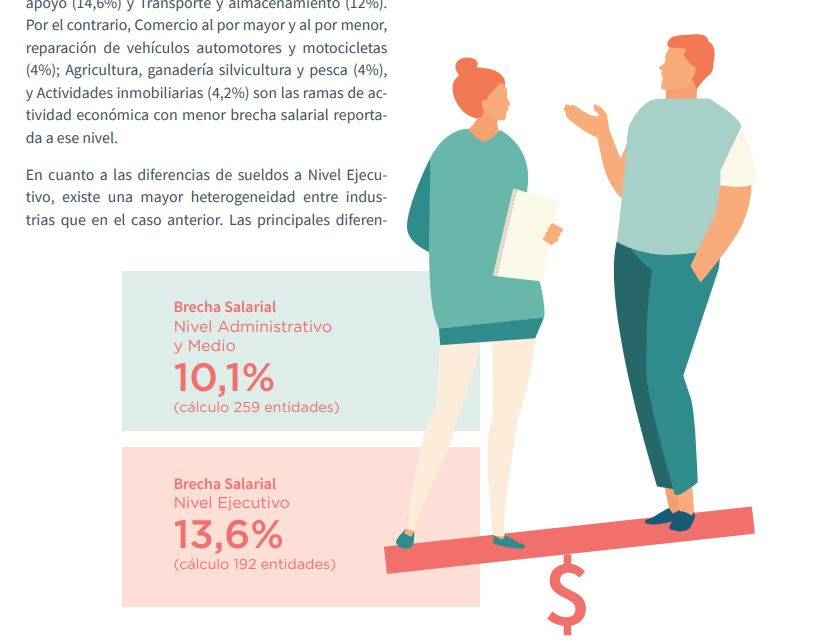

In [8]:
from IPython.display import Image

Image(filename = "fotos/indicadores_genero.jpg")

En este caso da lo mismo igual, las mujeres ganan menos mirándolo desde todos los ángulos. Viva Chile. 

También está el caso del banco central y su informe de [Brechas de Género y Desempeño Macroeconómico](https://www.bcentral.cl/documents/33528/133214/rcc-15032023.pdf/abba5a48-0186-0e8e-e4c9-f7e91cb2387a?t=1678899962437) de este año, que justamente controla por una chorrera de variables y todas sus combinaciones para estimar el promedio de la brecha:

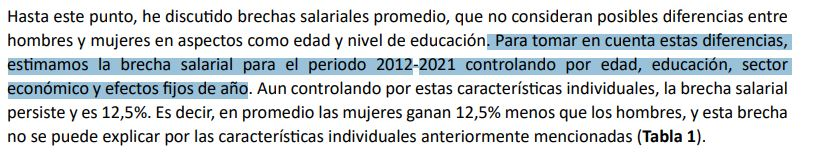

In [9]:
Image(filename = "fotos/bco_central.jpg")

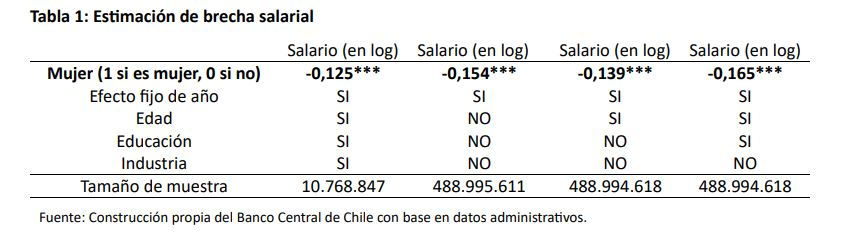

In [10]:
Image(filename = "fotos/bco_central2.jpg")

Esto no está necesariamente mal pero tiene poco sentido si no concuerda con algún modelo causal declarado, como para poder evaluar la pertinencia de controlar o no por ciertas variables, bajo el supuesto que lo que se quiere estimar es el efecto del género a la diferencia salarial. 

### Conclusiones

La conclusión principal es que siempre hay que desconfiar de los datos (cuec, aló cadem). Presentarlos de una u otra forma puede ser una manera de dar vuelta hechos irrefutables, en algunos casos de manera maliciosa, o maquillarlos de manera inadvertida. Si no está presentado el grafo causal que representa el problema que se investiga es difícil evaluar los resultados. El grafo define las relaciones que las variables pueden tener y por lo tanto es testeable respecto a datos observados; define las dependencias/independencias de las variables y se pueden comprobar sin necesidad de experimentos. En otras palabras, en el grafo se transparenta todo el conocimiento respecto al tema de quien expone y simplifica el proceso de revisión por parte de otras personas.

Hay un problema bien grande de controlar por variables que uno no debería lo cuál genera relaciones espúreas que lleva a concluir cuestiones totalmente erradas. No es la idea de este blog, pero a quien le interese creo que [Causal Inference in Statistics, a Primer](https://www.amazon.com/-/es/Judea-Pearl/dp/1119186846) es re bueno introductorio para quien ya sepa un poco de estadísticas, o pueden leer primero [A book of why](https://www.amazon.com/-/es/Judea-Pearl/dp/046509760X) si les gustan más los libros de difusión. La última recomendación (y la única gratis) es el libro que está totalmente liberado en web [The Effect](https://theeffectbook.net/)

TL;DR Básicamente teman cada vez que controlan, o no, por alguna variable. 